In [1]:
import pandas as pd
import numpy as np
import sys
import importlib
sys.path.insert(0, '../')
from utilities.utils import Utils
#from cross_validation import CrossValidation
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
import plotManager
importlib.reload(plotManager)

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
data_path = Utils.load_config("PREPROCESSED_DATASET_PATH")

df = pd.read_csv(data_path, index_col='date', parse_dates=True)
df.drop('instant',axis=1,inplace=True)
df.head()

,year,workingday,temp,humidity,windspeed,rentals,season_1,season_2,season_3,season_4,...,hour_21,hour_22,hour_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,0,0,0.226,0.793,0.0,16,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2011-01-01 01:00:00,0,0,0.206,0.783,0.0,40,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2011-01-01 02:00:00,0,0,0.206,0.783,0.0,32,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2011-01-01 03:00:00,0,0,0.226,0.728,0.0,13,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2011-01-01 04:00:00,0,0,0.226,0.728,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Building the MLP Model for prediction

In [3]:
predictors = ['year','workingday','temp','humidity','windspeed','season_1','season_2','season_3','season_4',
              'month_1','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10',
              'month_11','month_12','weather_1','weather_2','weather_3','weather_4','hour_0','hour_1','hour_2',
              'hour_3','hour_4','hour_5','hour_6','hour_7','hour_8','hour_9','hour_10','hour_11','hour_12','hour_13',
              'hour_14','hour_15','hour_16','hour_17','hour_18','hour_19','hour_20','hour_21','hour_22','hour_23',
              'weekday_0','weekday_1','weekday_2','weekday_3','weekday_4','weekday_5','weekday_6']

y = df['rentals']
x = df[predictors]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=100, shuffle=False)

regressor = MLPRegressor(hidden_layer_sizes=(24), max_iter=600, random_state = 0, shuffle=False) 
regressor.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=24, max_iter=600, random_state=0, shuffle=False)

In [4]:
predicted = regressor.predict(X_test)
predicted

array([ 59.91403275,  42.84558075,  51.46751677, ..., 176.72094232,
       149.31640559,  99.95397233])

## Cross Validation

In [7]:
def count_combinations(dict_, counter=0):
    res = 1;
    for each_key in dict_:
        res *= len(dict_[each_key])
    return res

def get_MAE(y_test, predicted_labels):
    return metrics.mean_absolute_error(y_test, predicted_labels)

def get_MSE(y_test, predicted_labels):
    return metrics.mean_squared_error(y_test, predicted_labels)
    
def get_RMSE(y_test, predicted_labels):
    return np.sqrt(metrics.mean_squared_error(y_test, predicted_labels))

def get_MAPE(y_test, predicted_labels):
    return metrics.mean_absolute_percentage_error(y_test, predicted_labels)

def get_MAXE(y_test, predicted_labels):
    return metrics.max_error(y_test, predicted_labels)

# dictonary with paramters to tune
tuning_parameters = {
    'hidden_layer_sizes': [(24),(24,12), (24,12,6)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive', 'invscaling'],
}

total_iter = count_combinations(tuning_parameters)

In [ ]:
cv_results = pd.DataFrame(columns=['parameter_combo', 'MAE', 'MSE', 'RMSE', 'MAPE', 'MAXE'])
iteration = 0

for hl_size in tuning_parameters['hidden_layer_sizes']:
    for act in tuning_parameters['activation']:
        for solv in tuning_parameters['solver']:
            for a in tuning_parameters['alpha']:
                for learn_rate in tuning_parameters['learning_rate']:
                    iteration = iteration + 1
                    progress = round((iteration/total_iter)*100, 2)

                    print(str(progress) + '% trying combination: size->' + str(hl_size) +
                          ' activation->'+ str(act) +
                          ' solver->' + str(solv) +
                          ' alpha->' + str(a) +
                          ' learning_rate->' + str(learn_rate))
                   
                    reg_model = MLPRegressor(hidden_layer_sizes=hl_size, activation=act, solver=solv,
                                             alpha=a, learning_rate=learn_rate, max_iter=600, random_state = 0, shuffle=False) 

                    try:
                        reg_model.fit(X_train, y_train)
                   
                        parameter_combo = str(hl_size) + ' - '+ str(act) + ' - ' + str(solv) + ' - ' + str(a) + ' - ' + str(learn_rate)
                        predicted_lab = reg_model.predict(X_test)

                        MAE = get_MAE( y_test, predicted_lab)
                        MSE = get_MSE( y_test, predicted_lab)
                        RMSE = get_RMSE( y_test, predicted_lab)
                        MAPE = get_MAPE( y_test, predicted_lab)
                        MAXE = get_MAXE(y_test, predicted_lab) 

                        row = {'parameter_combo': parameter_combo, 'MAE': MAE, 'MSE': MSE, 'RMSE': RMSE, 'MAPE': MAPE, 'MAXE': MAXE }
                        cv_results = cv_results.append(row, ignore_index = True)
                    except:
                        print("An exception occurred at iteration " + str(iteration) + ' skipping...')        

In [ ]:
cv_results = cv_results.sort_values(by=['MAPE'])
cv_results

## Forecasting results

In [17]:
final_model = MLPRegressor(hidden_layer_sizes=(24, 12), activation='relu', solver='adam',
                          alpha=0.0001, learning_rate='invscaling', max_iter=600, random_state = 0, shuffle=False) 

final_model.fit(X_train, y_train)
predicted_final = final_model.predict(X_test)
predicted_final

array([ 39.35494845,  11.84058062,  14.45746702, ..., 183.66905158,
       133.66222306,  77.96379194])

In [18]:
new_df = y_test.copy()
new_df = new_df.to_frame()
new_df['predicted_rentals'] = predicted_final
new_df = new_df.sort_index()
new_df

MAE = get_MAE( y_test, predicted_final)
MSE = get_MSE( y_test, predicted_final)
RMSE = get_RMSE( y_test, predicted_final)
MAPE = get_MAPE( y_test, predicted_final)
MAXE = get_MAXE(y_test, predicted_final) 

print( 
      'Final Model\n' +
      'Mean absolute error: ' + str(MAE) + '\n' +
      'Mean square error: ' + str(MSE) + '\n' +
      'Root mean square error: ' + str(RMSE) + '\n' +
      'Mean absolute percentage error: ' + str(MAPE) + '\n' +
      'Max error: ' + str(MAXE)
     )

Final Model
Mean absolute error: 40.930449714700146
Mean square error: 4097.253960288593
Root mean square error: 64.00979581508281
Mean absolute percentage error: 0.4208121581250073
Max error: 448.7262645510692


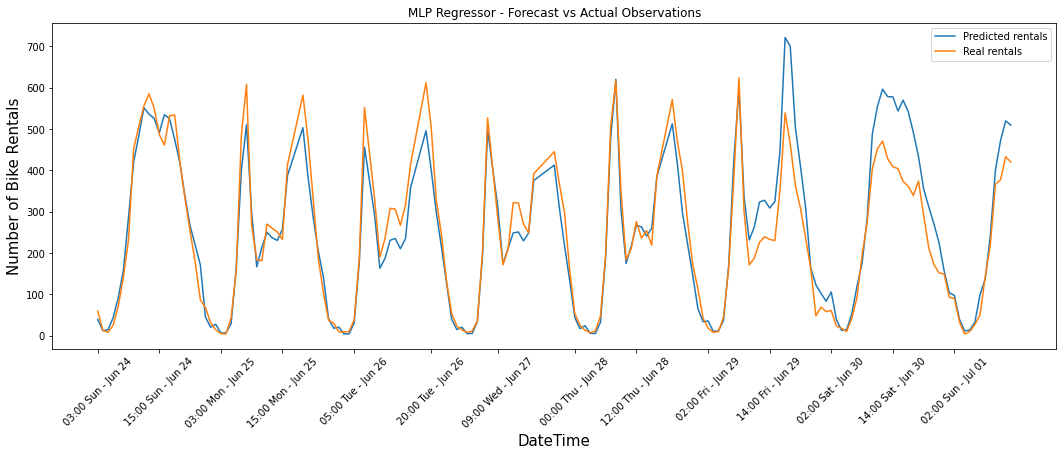

In [19]:
plotMan = plotManager.plotManager(new_df)
plotMan.forecast_plot(new_df)